In [1]:
import argparse
import json
import os
import sys
import time
from tqdm import tqdm
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

import pickle
import numpy as np
import torch
from pathlib import Path
import yaml
from det3d import torchie
import matplotlib.pyplot as plt
import cv2
import PIL
import open3d as o3d
from det3d.datasets import build_dataloader, build_dataset
from det3d.models import build_detector
from det3d.torchie import Config
from det3d.torchie.apis import (
    batch_processor,
    build_optimizer,
    get_root_logger,
    init_dist,
    set_random_seed,
    train_detector,
)
from det3d.torchie.trainer import load_checkpoint
from det3d.core import box_np_ops
from yoloX.yolox_utils import get_model, fuse_model, preproc, postprocess, visual

import open3d as o3d
import copy

# 주피터 노트북 경로설정
os.chdir('../')

def parse_args():
    parser = argparse.ArgumentParser(description="Train a detector")
    # parser.add_argument("--config", default="configs/onlypoints/pp/onlypoints_centerpoint_pp.py", help="train config file path")
    parser.add_argument("--config", default="configs/onlypoints/pp/kitech_centerpoint_pp.py", help="train config file path")
    parser.add_argument("--work_dir", help="the dir to save logs and models")
    parser.add_argument("--resume_from", help="the checkpoint file to resume from")
    parser.add_argument(
        "--validate",
        action="store_true",
        help="whether to evaluate the checkpoint during training",
    )
    parser.add_argument(
        "--gpus",
        type=int,
        default=1,
        help="number of gpus to use " "(only applicable to non-distributed training)",
    )
    parser.add_argument("--seed", type=int, default=None, help="random seed")
    parser.add_argument(
        "--launcher",
        choices=["pytorch", "slurm"],
        default="pytorch",
        help="job launcher",
    )
    parser.add_argument("--local_rank", type=int, default=0)
    parser.add_argument(
        "--autoscale-lr",
        action="store_true",
        help="automatically scale lr with the number of gpus",
    )
    args = parser.parse_args(args=[])
    if "LOCAL_RANK" not in os.environ:
        os.environ["LOCAL_RANK"] = str(args.local_rank)

    return args
args = parse_args()
cfg = Config.fromfile(args.config)
# distribution 설정 안함
cfg.local_rank = args.local_rank 

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
no apex
nuScenes devkit not Found!
No Tensorflow
Deformable Convolution not built!
No APEX!


In [2]:
# init logger before other steps
distributed = False
cfg.gpus = args.gpus
logger = get_root_logger(cfg.log_level)
logger.info("Distributed training: {}".format(distributed))
logger.info(f"torch.backends.cudnn.benchmark: {torch.backends.cudnn.benchmark}")

2024-05-03 16:12:14,312 - INFO - Distributed training: False
2024-05-03 16:12:14,313 - INFO - torch.backends.cudnn.benchmark: False


In [3]:
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)

2024-05-03 16:12:14,458 - INFO - Finish RPN Initialization
2024-05-03 16:12:14,459 - INFO - num_classes: [2, 2, 1, 1, 2, 1]


Use HM Bias:  -2.19


2024-05-03 16:12:14,470 - INFO - Finish CenterHead Initialization


In [4]:
args.testset = False
dataset = build_dataset(cfg.data.test)

In [5]:
dataset[0]

{'metadata': {'data_root': PosixPath('data/kitech'),
  'image_prefix': PosixPath('rgbd'),
  'pcd_prefix': PosixPath('pcd'),
  'num_point_features': 3,
  'filename': PosixPath('000000.pcd')},
 'points': array([[-0.03589651,  1.7576184 , -1.2710507 ],
        [-0.06780919,  3.3488035 , -0.7415345 ],
        [-0.03598173,  1.7924799 , -1.21391   ],
        ...,
        [ 1.9557557 ,  3.3441942 ,  0.09440535],
        [ 1.9580115 ,  3.3467143 , -0.86768043],
        [ 1.9585046 ,  3.3462138 ,  0.23889977]], dtype=float32),
 'voxels': array([[[-0.03589651,  1.7576184 , -1.2710507 ],
         [-0.03598173,  1.7924799 , -1.21391   ],
         [-0.02953166,  1.7442122 , -1.2674272 ],
         ...,
         [-0.1623371 ,  1.6767346 , -1.2513804 ],
         [-0.17214835,  1.784557  , -1.21391   ],
         [-0.15785502,  1.6888044 , -1.2544863 ]],
 
        [[-0.06780919,  3.3488035 , -0.7415345 ],
         [-0.06686067,  3.3307574 , -0.6254072 ],
         [-0.06620745,  3.3565233 , -0.5062852 ]

In [6]:
args.speed_test = True
data_loader = build_dataloader(
        dataset,
        batch_size=cfg.data.samples_per_gpu if not args.speed_test else 1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=distributed,
        shuffle=False,
    )

In [7]:
args.checkpoint = "modelzoo/etri3D_pointpillar/etri3D_latest.pth"
checkpoint = load_checkpoint(model, args.checkpoint, map_location="cpu")

In [8]:
model = model.cuda()
model.eval()
mode = "test"

In [9]:
logger.info(f"work dir: {args.work_dir}")
detections = {}
cpu_device = torch.device("cpu")

start = time.time()

start = int(len(dataset) / 3)
end = int(len(dataset) * 2 /3)

time_start = 0 
time_end = 0 

2024-05-03 16:12:16,162 - INFO - work dir: None


In [10]:
print(dataset[0])

{'metadata': {'data_root': PosixPath('data/kitech'), 'image_prefix': PosixPath('rgbd'), 'pcd_prefix': PosixPath('pcd'), 'num_point_features': 3, 'filename': PosixPath('000000.pcd')}, 'points': array([[-0.03589651,  1.7576184 , -1.2710507 ],
       [-0.06780919,  3.3488035 , -0.7415345 ],
       [-0.03598173,  1.7924799 , -1.21391   ],
       ...,
       [ 1.9557557 ,  3.3441942 ,  0.09440535],
       [ 1.9580115 ,  3.3467143 , -0.86768043],
       [ 1.9585046 ,  3.3462138 ,  0.23889977]], dtype=float32), 'voxels': array([[[-0.03589651,  1.7576184 , -1.2710507 ],
        [-0.03598173,  1.7924799 , -1.21391   ],
        [-0.02953166,  1.7442122 , -1.2674272 ],
        ...,
        [-0.1623371 ,  1.6767346 , -1.2513804 ],
        [-0.17214835,  1.784557  , -1.21391   ],
        [-0.15785502,  1.6888044 , -1.2544863 ]],

       [[-0.06780919,  3.3488035 , -0.7415345 ],
        [-0.06686067,  3.3307574 , -0.6254072 ],
        [-0.06620745,  3.3565233 , -0.5062852 ],
        ...,
        [-0

In [11]:
# YOLOX
# yolox_pth_path = "modelzoo/yolox/yolox_tiny_idgranter.pth.tar"
yolox_pth_path = "modelzoo/yolox/ocsort_x_mot20.pth.tar"
device = "cuda:0"
ckpt = torch.load(yolox_pth_path, map_location=device)

model2D = get_model(depth=1.33, width=1.25).to(device)
model2D.load_state_dict(ckpt["model"])
model2D = fuse_model(model2D)

class Predictor():
    """
    YOLOX inference calss
    """
    def __init__(self, model, image_size, device, nms_thre):
        self.model = model
        self.device = device
        self.image_size = image_size
        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)
        self.nms_thre = nms_thre
        self.campos = 0

    def inference(self, img):
        """
        Inference bounding boxes
        Args:
            img (array): images

        Returns:
            bounding boxes
        """
        x, _ = preproc(img, self.image_size, self.mean, self.std)
        x = torch.from_numpy(x).unsqueeze(0).float().to(self.device)
        output = self.model(x)
        output2 = postprocess(output, num_classes=1,
                              conf_thre=0.1, nms_thre=self.nms_thre)

        return output2
    
nms_thre = 0.5
test_size = (800, 1440)
predictor = Predictor(model2D, test_size, device, nms_thre)
# img = np.ascontiguousarray(img, dtype=np.uint8)

In [12]:
Path(str(dataset[0]['metadata']['filename'].stem) + "_rgb.jpg")

PosixPath('000000_rgb.jpg')

In [13]:
load_from = "kitech_inputoutput_result.pickle"
if os.path.exists(load_from):
    with open(load_from, "rb") as f:
        input_output = pickle.load(f)
else:
	input_output = {"file_name": [], "points": [], "gt_boxes": [], "gt_classes": [], "output_boxes": [], "output_classes": [], "output_scores": [], "2D_states": []}
	torch.multiprocessing.set_sharing_strategy('file_system')
	for i, data_batch in tqdm(enumerate(data_loader)):
		if i == start:
			torch.cuda.synchronize()
			time_start = time.time()

		if i == end:
			torch.cuda.synchronize()
			time_end = time.time()

		with torch.no_grad():
			outputs = batch_processor(
				model, data_batch, train_mode=False, local_rank=args.local_rank,
			)
		for j, output in enumerate(outputs):
			input_output["points"].append(data_batch['points'][j].cpu().numpy())
			input_output["file_name"].append(data_batch['metadata'][j]['filename'])
			rgb = Path(str(data_batch['metadata'][j]['filename'].stem) + "_rgb.jpg")
			file = Path(cfg.data_root)/Path("rgbd")/rgb
			img = np.array(PIL.Image.open(file), dtype=np.uint8)
			with torch.no_grad():
				outputs_2D = predictor.inference(img[..., :3])
			input_output["2D_states"].append(outputs_2D[0])
			# gt_boxes = []
			# for ts in data_batch['anno_box']:
			#     ts2 = ts[j]
			#     gt_boxes.extend(ts2.cpu().numpy())
			# input_output["gt_boxes"].append(np.array(gt_boxes))
			# gt_classes = []
			# idx = 0
			# for k in range(data_batch["anno_cls"][j].shape[0]):
			#     head_classes = cfg.tasks[k]
			#     class_names = head_classes['class_names']
			#     head_class_ids = data_batch['anno_cls'][j][k]
			#     for l in range(len(head_class_ids)):
			#         _id = head_class_ids[l] - 1
			#         gt_classes.append(idx+_id)
			#     idx += len(class_names)
			input_output["output_classes"].append(output['label_preds'].cpu().numpy())
			# input_output["gt_classes"].append(np.array(gt_classes))
			input_output["output_boxes"].append(output["box3d_lidar"].cpu().numpy())
			input_output["output_scores"].append(output['scores'].cpu().numpy())

In [14]:
line_list = [[0, 1],
             [1, 2],
             [2, 3],
             [3, 0],
             [4, 5],
             [5, 6],
             [6, 7],
             [7, 4],
             [0, 4],
             [1, 5],
             [2, 6],
             [3, 7]]

# calib = np.array([[-0.99983949, -0.01008867, -0.01480574, 0.05565861],
# [0.01433594, 0.04514753, -0.99887746, 0.08249057],
# # [0.01074579, -0.99892939, -0.04499565, -0.00898347],
# [0.01074579, -0.99892939, -0.04499565, 0.8-0.00898347],
# [0, 0, 0, 1]])
# offset = [[1,0,0,0], [0,1,0,0], [0,0,1,0.8],[0,0,0,1]]
# cam = np.array([[1076.7392578125, 0.0, 957.8059692382812],
# [0.0, 1076.7392578125, 546.310791015625],
# [0.0, 0.0, 1.0]])
cam = np.zeros([3,3])
cam[0,0] = 262.49102783203125
cam[1,1] = 262.49102783203125
cam[2,2] = 1
cam[0,2] = 327.126708984375
cam[1,2] = 184.74203491210938
calib = np.array([[ 0, -1,  0,  0.02],
                  [ 0,  0, -1, -0.17],
                  [ 1,  0,  0, -0.06]])
offset = np.identity(4)

In [15]:
# for i in tqdm(range(len(input_output["points"]))):
# 	points_v = input_output["points"][i]
# 	pred_boxes = input_output["output_boxes"][i]
# 	scores = input_output["output_scores"][i]
# 	mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2, origin=[0,0,0])
# 	pcd = o3d.geometry.PointCloud()
# 	pcd.points = o3d.utility.Vector3dVector(points_v)
# 	entities_to_draw = [pcd, mesh_frame]
# 	boxes3d_pts_list = []
 
# 	# pred_boxes 그리기
# 	for idx in range(len(pred_boxes)):
# 		# if scores[idx] < 0.3:
# 		# 	continue
# 		if input_output["output_classes"][i][idx] != 8:
# 			continue
# 		translation = pred_boxes[idx][:3]
# 		w, l, h = pred_boxes[idx][3], pred_boxes[idx][4], pred_boxes[idx][5]
# 		rotation = pred_boxes[idx][-1]

# 		bounding_box = np.array([
# 						[-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
# 						[w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
# 						[-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]]) 
# 		rotation_matrix = np.array([
# 				[np.cos(rotation), -np.sin(rotation), 0.0],
# 				[np.sin(rotation), np.cos(rotation), 0.0],
# 				[0.0, 0.0, 1.0]])
# 		eight_points = np.tile(translation, (8, 1))

# 		corner_box = np.dot(rotation_matrix, bounding_box) + eight_points.transpose()
# 		boxes3d_pts = corner_box.transpose()
# 		boxes3d_pts[:, 2] = np.clip(boxes3d_pts[:, 2], -1.5, 60) # 박스의 아랫부분을 잘라내기 위한 클리핑
# 		boxes3d_pts = boxes3d_pts.T
		
# 		boxes3d_pts = o3d.utility.Vector3dVector(boxes3d_pts.T)
# 		boxes3d_pts_list.append(np.asarray(boxes3d_pts))
# 		box = o3d.geometry.OrientedBoundingBox.create_from_points(boxes3d_pts)
# 		box.color = [1, 0, 0]           #Box color would be red box.color = [R,G,B]
# 		entities_to_draw.append(box)

# 	file = Path("data/test/camera")/input_output["file_name"][i].with_suffix('.png')
# 	img = np.array(PIL.Image.open(file), dtype=np.uint8)
# 	fig = plt.figure(figsize=(20,20))
# 	img2 = copy.deepcopy(img)
# 	img3 = copy.deepcopy(img)
# 	img4 = copy.deepcopy(img)
 
# 	for j in range(len(boxes3d_pts_list)):
# 		# box_pt: (8, 3)
# 		boxes3d_pts_list[j] = np.concatenate((boxes3d_pts_list[j], np.ones((boxes3d_pts_list[j].shape[0], 1))), axis=1)
# 		boxes3d_pts_list[j] = np.matmul(cam, np.matmul(np.matmul(calib, offset), boxes3d_pts_list[j].T).T[:, :3].T).T
		
# 		for k in range(boxes3d_pts_list[j].shape[0]):
# 			boxes3d_pts_list[j][k, 0] = boxes3d_pts_list[j][k, 0] / boxes3d_pts_list[j][k, 2]
# 			boxes3d_pts_list[j][k, 1] = boxes3d_pts_list[j][k, 1] / boxes3d_pts_list[j][k, 2]
# 			boxes3d_pts_list[j][k, 2] = 1

# 		for l in range(len(line_list)):
# 			pnts = line_list[l]
# 			cv2.line(img2, (boxes3d_pts_list[j][pnts[0], 0].astype(np.int32), boxes3d_pts_list[j][pnts[0], 1].astype(np.int32)), (boxes3d_pts_list[j][pnts[1], 0].astype(np.int32), boxes3d_pts_list[j][pnts[1], 1].astype(np.int32)), (255, 0, 0), thickness = 5)
# 			cv2.line(img4, (boxes3d_pts_list[j][pnts[0], 0].astype(np.int32), boxes3d_pts_list[j][pnts[0], 1].astype(np.int32)), (boxes3d_pts_list[j][pnts[1], 0].astype(np.int32), boxes3d_pts_list[j][pnts[1], 1].astype(np.int32)), (255, 0, 0), thickness = 5)
# 	ax1 = fig.add_subplot(2, 2, 1)
# 	ax1.imshow(img)
# 	ax1.set_title('raw image')
# 	ax1.axis("off")
	
# 	ax2 = fig.add_subplot(2, 2, 2)
# 	ax2.imshow(img2)
# 	ax2.set_title('projected 3D boxes')
# 	ax2.axis("off")
 
# 	points_v_appended =  np.concatenate((points_v, np.ones((points_v.shape[0], 1))), axis=1)
# 	cam_points = np.matmul(cam, np.matmul(np.matmul(calib, offset), points_v_appended.T).T[:, :3].T).T
# 	for k in range(cam_points.shape[0]):
# 		cam_points[k, 0] = cam_points[k, 0] / cam_points[k, 2]
# 		cam_points[k, 1] = cam_points[k, 1] / cam_points[k, 2]
# 		cam_points[k, 2] = 1
# 	for l in range(cam_points.shape[0]):
# 		pnts = cam_points[l, :]
# 		if 0 <= pnts[0].astype(np.int32) < 1920 and 0 <= pnts[1].astype(np.int32) < 1080:
# 			cv2.line(img3, (pnts[0].astype(np.int32), pnts[1].astype(np.int32)), (pnts[0].astype(np.int32), pnts[1].astype(np.int32)), (255, 0, 0), thickness = 5)
# 	ax3 = fig.add_subplot(2, 2, 3)
# 	ax3.imshow(img3)
# 	ax3.set_title('projected points')
# 	ax3.axis("off")
# 	if input_output["2D_states"][i] is not None:
# 		result_img_rgb, bboxes, scores, cls, cls_names = visual(input_output["2D_states"][i], img4, test_size, cls_conf=0.5)
# 	else:
# 		result_img_rgb = img4

# 	ax4 = fig.add_subplot(2, 2, 4)
# 	ax4.imshow(img4)
# 	ax4.set_title('2D boxes and projected 3D boxes')
# 	ax4.axis("off")
# 	fig.savefig("/home/jaelee/objdect/CenterPoint/plot_results/" + str(input_output["file_name"][i].with_suffix('.png')))

  0%|          | 0/11077 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/kitech/objdect/CenterPoint/data/test/camera/000000.png'

In [15]:
outputs[0]

NameError: name 'outputs' is not defined

In [16]:
# line_list = [[0, 1],
#              [1, 2],
#              [2, 3],
#              [3, 0],
#              [4, 5],
#              [5, 6],
#              [6, 7],
#              [7, 4],
#              [0, 4],
#              [1, 5],
#              [2, 6],
#              [3, 7]]
# calib = np.array([[-0.99983949, -0.01008867, -0.01480574, 0.05565861],
# [0.01433594, 0.04514753, -0.99887746, 0.08249057],
# # [0.01074579, -0.99892939, -0.04499565, -0.00898347],
# [0.01074579, -0.99892939, -0.04499565, -0.80898347],
# [0, 0, 0, 1]])
# # calib = np.linalg.inv(calib)
# cam = np.array([[1076.7392578125, 0.0, 957.8059692382812],
# [0.0, 1076.7392578125, 546.310791015625],
# [0.0, 0.0, 1.0]])
# offset = [[1,0,0,0], [0,1,0,0], [0,0,1,0.8],[0,0,0,1]]
# for idx1 in range(len(input_output["file_name"])):
# 	points_v = input_output["points"][idx1]
# 	pred_boxes = input_output["output_boxes"][idx1]
# 	scores = input_output["output_scores"][idx1]
# 	boxes3d_pts_list = []
	
# 	file = Path("data/test/camera")/input_output["file_name"][idx1].with_suffix('.png')
# 	img = np.array(PIL.Image.open(file), dtype=np.uint8)

# 	for idx2 in range(len(pred_boxes)):
# 		# if scores[idx] < 0.1:
# 		#         continue
# 		if input_output["output_classes"][idx1][idx2] != 8:
# 			continue
# 		translation = pred_boxes[idx2][:3]
# 		w, l, h = pred_boxes[idx2][3], pred_boxes[idx2][4], pred_boxes[idx2][5]
# 		rotation = pred_boxes[idx2][-1]

# 		bounding_box = np.array([
# 						[-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
# 						[w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
# 						[-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]]) 
# 		rotation_matrix = np.array([
# 				[np.cos(rotation), -np.sin(rotation), 0.0],
# 				[np.sin(rotation), np.cos(rotation), 0.0],
# 				[0.0, 0.0, 1.0]])
# 		eight_points = np.tile(translation, (8, 1))

# 		corner_box = np.dot(rotation_matrix, bounding_box) + eight_points.transpose()
# 		boxes3d_pts = corner_box.transpose()
# 		boxes3d_pts = boxes3d_pts.T
# 		boxes3d_pts = o3d.utility.Vector3dVector(boxes3d_pts.T)
# 		boxes3d_pts_list.append(np.asarray(boxes3d_pts))
# 		for j in range(len(boxes3d_pts_list)):
# 			# box_pt: (8, 3)
# 			boxes3d_pts_list[j] = np.concatenate((boxes3d_pts_list[j], np.ones((boxes3d_pts_list[j].shape[0], 1))), axis=1)
# 			boxes3d_pts_list[j] = np.matmul(cam, np.matmul(np.matmul(calib, offset), boxes3d_pts_list[j].T).T[:, :3].T).T
# 			# boxes3d_pts_list[j] = np.matmul(cam, np.matmul(np.matmul(calib, offset), boxes3d_pts_list[j].T).T[:, :3].T).T
# 			for k in range(boxes3d_pts_list[j].shape[0]):
# 				boxes3d_pts_list[j][k, 0] = boxes3d_pts_list[j][k, 0] / boxes3d_pts_list[j][k, 2]
# 				boxes3d_pts_list[j][k, 1] = boxes3d_pts_list[j][k, 1] / boxes3d_pts_list[j][k, 2]
# 				boxes3d_pts_list[j][k, 2] = 1

# 				for l in range(len(line_list)):
# 					pnts = line_list[l]
# 					cv2.line(img, (boxes3d_pts_list[j][pnts[0], 0].astype(np.int32), boxes3d_pts_list[j][pnts[0], 1].astype(np.int32)), (boxes3d_pts_list[j][pnts[1], 0].astype(np.int32), boxes3d_pts_list[j][pnts[1], 1].astype(np.int32)), (0, 255, 0), 2)
# 		plt.imsave(f"/home/jaelee/objdect/CenterPoint/plot_results/" + str(input_output["file_name"][idx1].with_suffix('.png')), img)

In [17]:
# line_list = [[0, 1],
#              [1, 2],
#              [2, 3],
#              [3, 0],
#              [4, 5],
#              [5, 6],
#              [6, 7],
#              [7, 4],
#              [0, 4],
#              [1, 5],
#              [2, 6],
#              [3, 7]]

# calib = np.array([[-0.99983949, -0.01008867, -0.01480574, 0.05565861],
# [0.01433594, 0.04514753, -0.99887746, 0.08249057],
# # [0.01074579, -0.99892939, -0.04499565, -0.00898347],
# [0.01074579, -0.99892939, -0.04499565, 0.8-0.00898347],
# [0, 0, 0, 1]])
# offset = [[1,0,0,0], [0,1,0,0], [0,0,1,0.8],[0,0,0,1]]
# cam = np.array([[1076.7392578125, 0.0, 957.8059692382812],
# [0.0, 1076.7392578125, 546.310791015625],
# [0.0, 0.0, 1.0]])

In [18]:
cam = np.zeros([3,3])
cam[0,0] = 262.49102783203125
cam[1,1] = 262.49102783203125
cam[2,2] = 1
cam[0,2] = 327.126708984375
cam[1,2] = 184.74203491210938
calib = np.array([[ 0, -1,  0,  0.02],
                  [ 0,  0, -1, -0.17],
                  [ 1,  0,  0, -0.06]])
calib4 = np.concatenate((calib, np.array([[0,0,0,1]])), axis=0)
inv_camlib4 = np.linalg.inv(calib4)
inv_cam = np.linalg.inv(cam)
offset = np.identity(4)

def box3d_lidar_to_img(lidar_states):
	"""
	Args:
		lidar_states (list(numpy.array)): 3D Box 정보를 담은 8 X 3 array의 리스트
	Return:
		img 좌표계에서의 states x, y, 1를 담은 N x 3 array의 리스트
	"""
	for j in range(len(lidar_states)):
		# box_pt: (8, 3)
		lidar_states[j] = np.concatenate((lidar_states[j], np.ones((lidar_states[j].shape[0], 1))), axis=1)
		lidar_states[j] = np.matmul(cam, np.matmul(np.matmul(calib, offset), lidar_states[j].T).T[:, :3].T).T
		
		for k in range(lidar_states[j].shape[0]):
			lidar_states[j][k, 0] = lidar_states[j][k, 0] / lidar_states[j][k, 2]
			lidar_states[j][k, 1] = lidar_states[j][k, 1] / lidar_states[j][k, 2]
			lidar_states[j][k, 2] = 1
	return lidar_states # same as cam_states

def pnt2d_img_to_lidar(img_states, depth_img):
	"""
	Args:
		img_states (np.array): 2d 박스 x1y1x2y2 상태와 score, class 정보를 담은 N x 7 array
	Returns:
		2d box 가운데의 lidar 좌표계에서의 위치인 N x 3 array
	"""
	lidar_states = np.ones((4, img_states.shape[0]))
	img_states = img_states.cpu().numpy()
	bboxes = img_states[:, 0:4]

	# preprocessing: resize
	scale = min(
				test_size[0] / float(depth_img.shape[0]), test_size[1] / float(depth_img.shape[1])
			)
	bboxes /= scale
	x_states = (bboxes[:, 0] + bboxes[:, 2]) // 2
	y_states = (bboxes[:, 1] + bboxes[:, 3]) // 2
	lidar_states[0, :] = x_states.T
	lidar_states[1, :] = y_states.T
	for i in range(img_states.shape[0]):
		z = depth_img[int(y_states[i]), int(x_states[i])]
		lidar_states[:3, i] *= z
	
	lidar_states[:3, :] = np.matmul(inv_cam, lidar_states[:3, :])
	lidar_states = np.matmul(inv_camlib4, lidar_states)
	return lidar_states

[Open3D INFO] Window window_18 created.


WebVisualizer(window_uid='window_18')

(-0.5, 639.5, 359.5, -0.5)

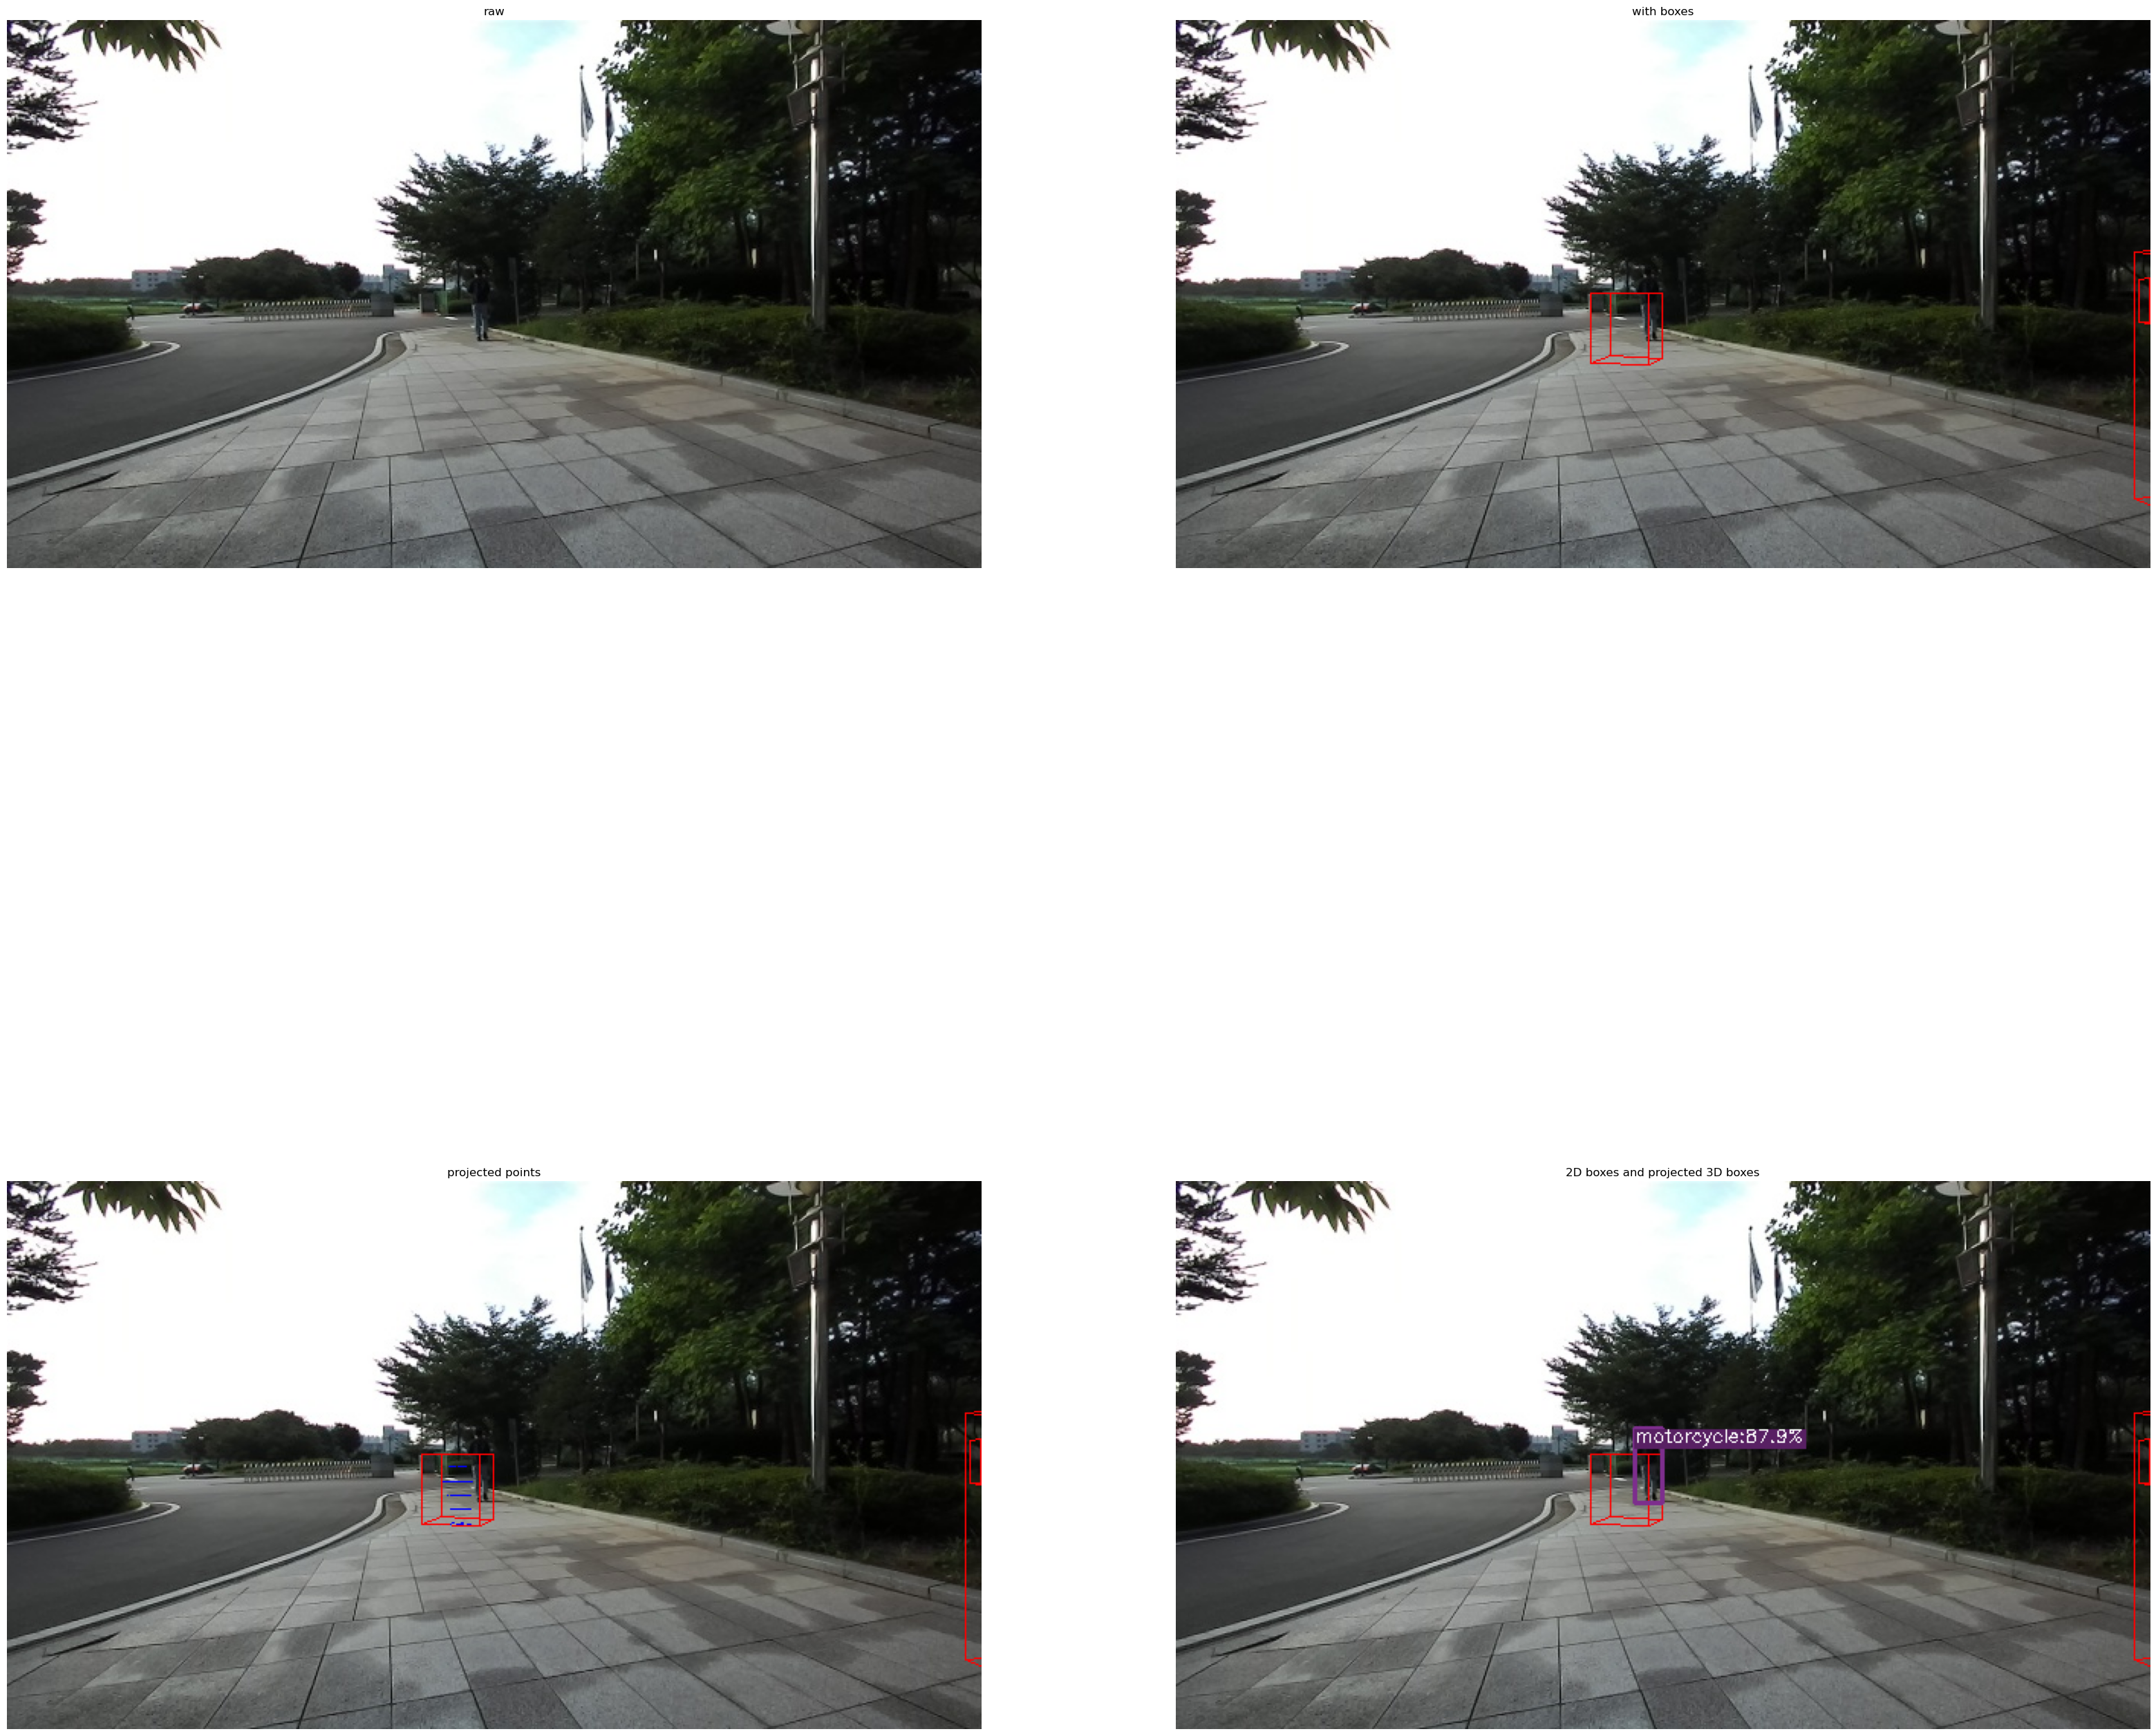

[Open3D INFO] Sending init frames to window_18.


[2231:738][12022] (stun_port.cc:96): Binding request timed out from 10.42.0.x:49136 (enp5s0)
[2231:738][12022] (stun_port.cc:96): Binding request timed out from 10.42.0.x:49136 (enp5s0)
[2276:043][12022] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[2276:407][12022] (dtls_transport.cc:529): DtlsTransport[0|1|__]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[2276:584][12022] (dtls_transport.cc:529): DtlsTransport[0|1|__]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[2276:715][12022] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[2276:730][12022] (dtls_transport.cc:529): DtlsTransport[0|1|__]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[2276:903][12022] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[2276:920][12022] (dtls_transport.cc:529): DtlsTransport[0|1|__]: OnWritable

In [49]:
import open3d as o3d
from open3d.web_visualizer import draw
import copy

# i = np.random.randint(0, 600)
i = 8000
points_v = input_output["points"][i]
# floor = np.where(points_v[:,2] <= -1.5)
# points_v = points_v[floor[0]]
pred_boxes = input_output["output_boxes"][i]
scores = input_output["output_scores"][i]
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2, origin=[0,0,0])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_v)
entities_to_draw = [pcd, mesh_frame]
boxes3d_pts_list = []
# pred_boxes 그리기
for idx in range(len(pred_boxes)):
	if scores[idx] < 0.5:
		continue
	if input_output["output_classes"][i][idx] != 8:
		continue
	translation = pred_boxes[idx][:3]
	if translation[0] <= 0.1:
		continue
	w, l, h = pred_boxes[idx][3], pred_boxes[idx][4], pred_boxes[idx][5]
	rotation = pred_boxes[idx][-1]

	bounding_box = np.array([
					[-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
					[w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
					[-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]]) 
	rotation_matrix = np.array([
			[np.cos(rotation), -np.sin(rotation), 0.0],
			[np.sin(rotation), np.cos(rotation), 0.0],
			[0.0, 0.0, 1.0]])
	eight_points = np.tile(translation, (8, 1))

	corner_box = np.dot(rotation_matrix, bounding_box) + eight_points.transpose()
	boxes3d_pts = corner_box.transpose()
	boxes3d_pts[:, 2] = np.clip(boxes3d_pts[:, 2], -1.6, 60) # 박스의 아랫부분을 잘라내기 위한 클리핑
	boxes3d_pts = boxes3d_pts.T
	
	boxes3d_pts = o3d.utility.Vector3dVector(boxes3d_pts.T)
	boxes3d_pts_list.append(np.asarray(boxes3d_pts))
	box = o3d.geometry.OrientedBoundingBox.create_from_points(boxes3d_pts)
	box.color = [1, 0, 0]           #Box color would be red box.color = [R,G,B]
	entities_to_draw.append(box)


file = Path(cfg.data_root)/Path("camera")/input_output["file_name"][i].with_suffix('.png')
rgb_name = Path(str(input_output["file_name"][i].stem) + "_rgb.jpg")
depth_name = Path(str(input_output["file_name"][i].stem) + "_d.png")
rgb_file = Path(cfg.data_root)/Path("rgbd")/rgb_name
depth_file = Path(cfg.data_root)/Path("rgbd")/depth_name
# file = Path("data/test/camera")/input_output["file_name"][i].with_suffix('.png')
img = np.array(PIL.Image.open(rgb_file), dtype=np.uint8)
depth = np.array(PIL.Image.open(depth_file), dtype=np.uint16) / 200
fig = plt.figure(figsize=(40,40))

img2 = copy.deepcopy(img)

# 2D_boxes 그리기
if input_output["2D_states"][i] is not None:
	depth_boxes = pnt2d_img_to_lidar(input_output["2D_states"][i], depth)[:3, :].T
	# pred_boxes 그리기
	for idx in range(depth_boxes.shape[0]):
		w = l = h = 1
		bounding_box = np.array([
						[-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
						[w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
						[-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]])
		translation = depth_boxes[idx, :]
		eight_points = np.tile(translation, (8, 1))
		rotation = np.array([[ 0.59587538,  0.80307692,  0.   ],
						[-0.80307692,  0.59587538,  0.        ],
						[ 0.,          0.,          1.        ]])
		corner_box = np.dot(rotation_matrix, bounding_box) + eight_points.transpose()
		boxes3d_pts = corner_box.transpose()
		# boxes3d_pts[:, 2] = np.clip(boxes3d_pts[:, 2], -1.6, 60) # 박스의 아랫부분을 잘라내기 위한 클리핑
		boxes3d_pts = boxes3d_pts.T
		
		boxes3d_pts = o3d.utility.Vector3dVector(boxes3d_pts.T)
		# boxes3d_pts_list.append(np.asarray(boxes3d_pts))
		box = o3d.geometry.OrientedBoundingBox.create_from_points(boxes3d_pts)
		box.color = [0, 0, 1]           #Box color would be red box.color = [R,G,B]
		entities_to_draw.append(box)


for j in range(len(boxes3d_pts_list)):
	# box_pt: (8, 3)
	boxes3d_pts_list[j] = np.concatenate((boxes3d_pts_list[j], np.ones((boxes3d_pts_list[j].shape[0], 1))), axis=1)
	boxes3d_pts_list[j] = np.matmul(cam, np.matmul(np.matmul(calib, offset), boxes3d_pts_list[j].T).T[:, :3].T).T
	
	for k in range(boxes3d_pts_list[j].shape[0]):
		boxes3d_pts_list[j][k, 0] = boxes3d_pts_list[j][k, 0] / boxes3d_pts_list[j][k, 2]
		boxes3d_pts_list[j][k, 1] = boxes3d_pts_list[j][k, 1] / boxes3d_pts_list[j][k, 2]
		boxes3d_pts_list[j][k, 2] = 1

	for l in range(len(line_list)):
		pnts = line_list[l]
		cv2.line(img2, (boxes3d_pts_list[j][pnts[0], 0].astype(np.int32), boxes3d_pts_list[j][pnts[0], 1].astype(np.int32)), (boxes3d_pts_list[j][pnts[1], 0].astype(np.int32), boxes3d_pts_list[j][pnts[1], 1].astype(np.int32)), (255, 0, 0), thickness = 1)
draw([*entities_to_draw])

img3 = copy.deepcopy(img2)
img4 = copy.deepcopy(img2)
rows = 2
cols = 2
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img)
ax1.set_title('raw')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(img2)
ax2.set_title('with boxes')
ax2.axis("off")

# Create boolean masks for each condition
mask1 = pred_boxes[..., 0] > 0.1
mask2 = scores >= 0.5
mask3 = input_output["output_classes"][i] == 8
# Combine all masks using logical AND operation
intersection_mask = np.logical_and(np.logical_and(mask1, mask2), mask3)
if pred_boxes[intersection_mask].shape[0]:
	point_indices = box_np_ops.points_in_rbbox(points_v, pred_boxes[intersection_mask])
	mask_boxes = np.zeros((point_indices.shape[0]))
	for j in range(point_indices.shape[1]):
		mask_boxes = np.logical_or(mask_boxes, point_indices[:, j])
	inboxpnts = points_v[ mask_boxes]
	points_v_appended =  np.concatenate((inboxpnts, np.ones((inboxpnts.shape[0], 1))), axis=1)
	# points_v_appended =  np.concatenate((points_v, np.ones((points_v.shape[0], 1))), axis=1)
	cam_points = np.matmul(cam, np.matmul(np.matmul(calib, offset), points_v_appended.T).T[:, :3].T).T
	for k in range(cam_points.shape[0]):
		cam_points[k, 0] = cam_points[k, 0] / cam_points[k, 2]
		cam_points[k, 1] = cam_points[k, 1] / cam_points[k, 2]
		cam_points[k, 2] = 1
	for l in range(cam_points.shape[0]):
		pnts = cam_points[l, :]
		if 0 <= pnts[0].astype(np.int32) < 1920 and 0 <= pnts[1].astype(np.int32) < 1080:
			cv2.line(img3, (pnts[0].astype(np.int32), pnts[1].astype(np.int32)), (pnts[0].astype(np.int32), pnts[1].astype(np.int32)), (0, 0, 255), thickness = 1)
ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(img3)
ax3.set_title('projected points')
ax3.axis("off")
if input_output["2D_states"][i] is not None:
	result_img_rgb, bboxes, scores, cls, cls_names = visual(input_output["2D_states"][i], img4, test_size, cls_conf=0.5)
else:
	result_img_rgb = img4

ax4 = fig.add_subplot(rows, cols, 4)
ax4.imshow(img4)
ax4.set_title('2D boxes and projected 3D boxes')
ax4.axis("off")
# fig.savefig("/home/jaelee/objdect/CenterPoint/plot_results/" + str(input_output["file_name"][i].with_suffix('.png')))

In [46]:
if pred_boxes[intersection_mask].shape[0]:
    print("yes")

In [44]:
pred_boxes[intersection_mask].shape

(0, 7)

In [35]:
mask_boxes.dtype

dtype('float64')

In [90]:
depth_boxes

array([[ 7.03      , -2.92405049, -0.09718996],
       [ 5.965     , -1.91180616, -0.08581916]])

In [86]:
corner_box

array([[ 5.465     ,  5.465     ,  6.465     ,  6.465     ,  5.465     ,
         5.465     ,  6.465     ,  6.465     ],
       [-1.41180616, -2.41180616, -2.41180616, -1.41180616, -1.41180616,
        -2.41180616, -2.41180616, -1.41180616],
       [-0.58581916, -0.58581916, -0.58581916, -0.58581916,  0.41418084,
         0.41418084,  0.41418084,  0.41418084]])

In [88]:
np.asarray(boxes3d_pts)

array([[ 5.465     , -1.41180616, -0.58581916],
       [ 5.465     , -2.41180616, -0.58581916],
       [ 6.465     , -2.41180616, -0.58581916],
       [ 6.465     , -1.41180616, -0.58581916],
       [ 5.465     , -1.41180616,  0.41418084],
       [ 5.465     , -2.41180616,  0.41418084],
       [ 6.465     , -2.41180616,  0.41418084],
       [ 6.465     , -1.41180616,  0.41418084]])

[22654:408][5054] (stun_port.cc:96): Binding request timed out from 10.42.0.x:50603 (enp5s0)
[22654:409][5054] (stun_port.cc:96): Binding request timed out from 10.42.0.x:50603 (enp5s0)


In [53]:
np.asarray(boxes3d_pts).shape

(8, 3)

In [69]:
pnt2d_img_to_lidar(input_output["2D_states"][i], depth)

array([[ 7.03      ,  5.965     ],
       [-2.92405049, -1.91180616],
       [-0.09718996, -0.08581916],
       [ 1.        ,  1.        ]])

In [17]:
output = input_output["2D_states"][i]
output = output.cpu()

bboxes = output[:, 0:4]

# preprocessing: resize
scale = min(
			test_size[0] / float(img.shape[0]), test_size[1] / float(img.shape[1])
		)
bboxes /= scale
bboxes

tensor([[426.3315, 149.0619, 451.0518, 216.2236],
        [398.8585, 151.8696, 428.4480, 211.6561]])

In [28]:
x = int((bboxes[0][0]+ bboxes[0][2])/2)
y = int((bboxes[0][1]+ bboxes[0][3])/2)
x, y

(438, 182)

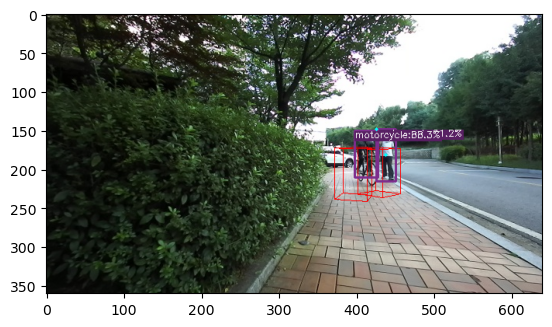

In [27]:
cv2.line(img4, (int((bboxes[0][0]+ bboxes[0][2])/2), int((bboxes[0][1]+ bboxes[0][3])/2)), (int((bboxes[0][0]+ bboxes[0][2])/2), int((bboxes[0][1]+ bboxes[0][3])/2)), (0, 255, 255), thickness = 3)
plt.imshow(img4)

In [30]:
z = depth[y, x]
z

6.97

In [41]:
calib

array([[ 0.  , -1.  ,  0.  ,  0.02],
       [ 0.  ,  0.  , -1.  , -0.17],
       [ 1.  ,  0.  ,  0.  , -0.06]])

In [43]:
np.append(calib, np.array([0,0,0,1]))

array([ 0.  , -1.  ,  0.  ,  0.02,  0.  ,  0.  , -1.  , -0.17,  1.  ,
        0.  ,  0.  , -0.06,  0.  ,  0.  ,  0.  ,  1.  ])

In [44]:
np.linalg.inv(np.append(calib, np.array([0,0,0,1])).reshape(4,4))

array([[ 0.  ,  0.  ,  1.  ,  0.06],
       [-1.  , -0.  , -0.  ,  0.02],
       [-0.  , -1.  , -0.  , -0.17],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [49]:
np.matmul(np.linalg.inv(calib4), np.append(np.matmul(np.linalg.inv(cam), np.array([x*z, y*z, z]).T), 1).reshape(4,1))

array([[ 7.03      ],
       [-2.92405049],
       [-0.09718996],
       [ 1.        ]])

In [56]:
pred_boxes[intersection_mask]

array([[ 7.297016  , -1.9220085 , -0.78029925,  1.0545511 ,  1.2534516 ,
         1.8353833 , -0.44767323],
       [ 7.9375534 , -3.0576897 , -0.81017214,  1.0454783 ,  1.2127018 ,
         1.8790768 , -0.93244106]], dtype=float32)

In [49]:
depth.shape

(360, 640)

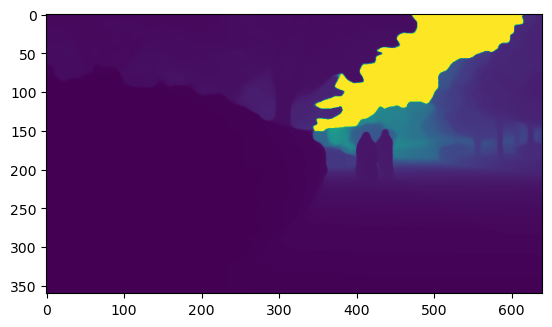

In [44]:
plt.imshow(depth)

In [32]:
point_indices.shape

(24801, 2)

[744:755][21082] (stun_port.cc:96): Binding request timed out from 10.42.0.x:43073 (enp5s0)
[744:759][21082] (stun_port.cc:96): Binding request timed out from 10.42.0.x:43073 (enp5s0)


In [116]:
# Create boolean masks for each condition
mask1 = pred_boxes[..., 0] > 0.1
mask2 = scores >= 0.8
mask3 = input_output["output_classes"][i] == 8

# Combine all masks using logical AND operation
intersection_mask = np.logical_and(np.logical_and(mask1, mask2), mask3)
intersection_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [124]:
point_indices = box_np_ops.points_in_rbbox(points_v, pred_boxes[intersection_mask])
inboxpnts = points_v[point_indices.flatten()]

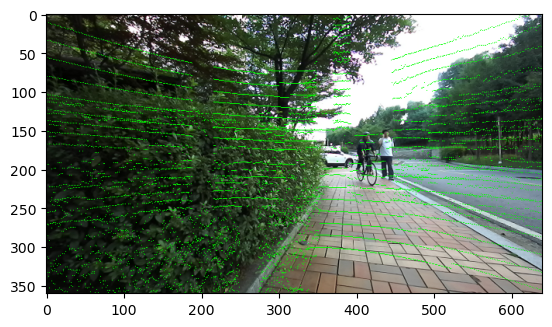

In [157]:
img = np.array(PIL.Image.open(file), dtype=np.uint8)
points_v_appended =  np.concatenate((points_v, np.ones((points_v.shape[0], 1))), axis=1)
# points_v_appended =  np.concatenate((inboxpnts, np.ones((inboxpnts.shape[0], 1))), axis=1)
cam_points = np.matmul(cam, np.matmul(np.matmul(calib, offset), points_v_appended.T).T[:, :3].T).T
for k in range(cam_points.shape[0]):
	cam_points[k, 0] = cam_points[k, 0] / cam_points[k, 2]
	cam_points[k, 1] = cam_points[k, 1] / cam_points[k, 2]
	cam_points[k, 2] = 1
for l in range(cam_points.shape[0]):
	pnts = cam_points[l, :]
	if 0 <= pnts[0].astype(np.int32) < 1920 and 0 <= pnts[1].astype(np.int32) < 1080:
		cv2.line(img, (pnts[0].astype(np.int32), pnts[1].astype(np.int32)), (pnts[0].astype(np.int32), pnts[1].astype(np.int32)), (0, 255, 0), thickness = 1)

plt.imshow(img)

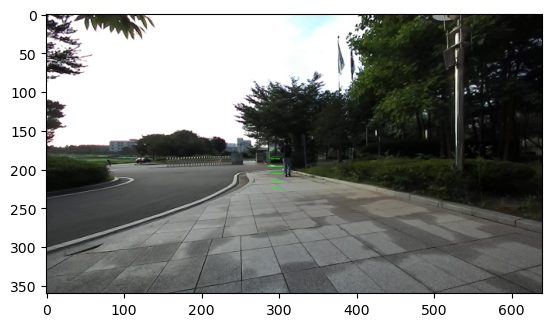

In [132]:
img = np.array(PIL.Image.open(file), dtype=np.uint8)
# points_v_appended =  np.concatenate((points_v, np.ones((points_v.shape[0], 1))), axis=1)
points_v_appended =  np.concatenate((inboxpnts, np.ones((inboxpnts.shape[0], 1))), axis=1)
cam_points = np.matmul(cam, np.matmul(np.matmul(calib, offset), points_v_appended.T).T[:, :3].T).T
for k in range(cam_points.shape[0]):
	cam_points[k, 0] = cam_points[k, 0] / cam_points[k, 2]
	cam_points[k, 1] = cam_points[k, 1] / cam_points[k, 2]
	cam_points[k, 2] = 1
for l in range(cam_points.shape[0]):
	pnts = cam_points[l, :]
	if 0 <= pnts[0].astype(np.int32) < 1920 and 0 <= pnts[1].astype(np.int32) < 1080:
		cv2.line(img, (pnts[0].astype(np.int32), pnts[1].astype(np.int32)), (pnts[0].astype(np.int32), pnts[1].astype(np.int32)), (0, 255, 0), thickness = 1)

plt.imshow(img)

In [ ]:
for l in tqdm(range(cam_points.shape[0])):
	pnts = cam_points[l, :]
	if 0 <= pnts[0].astype(np.int32) < 1920 and 0 <= pnts[1].astype(np.int32) < 1080:
		cv2.line(img, (pnts[0].astype(np.int32), pnts[1].astype(np.int32)), (pnts[0].astype(np.int32), pnts[1].astype(np.int32)), (255, 0, 0), thickness = 5)


In [ ]:
img.shape

## yolox

In [ ]:
# yolox_pth_path = "modelzoo/yolox/yolox_tiny_idgranter.pth.tar"
yolox_pth_path = "modelzoo/yolox/ocsort_x_mot20.pth.tar"
device = "cuda:0"
ckpt = torch.load(yolox_pth_path, map_location=device)

model = get_model(depth=1.33, width=1.25).to(device)
model.load_state_dict(ckpt["model"])
model = fuse_model(model)

img = np.array(PIL.Image.open(file), dtype=np.uint8)[..., :3]
class Predictor():
    """
    YOLOX inference calss
    """
    def __init__(self, model, image_size, device, nms_thre):
        self.model = model
        self.device = device
        self.image_size = image_size
        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)
        self.nms_thre = nms_thre
        self.campos = 0

    def inference(self, img):
        """
        Inference bounding boxes
        Args:
            img (array): images

        Returns:
            bounding boxes
        """
        x, _ = preproc(img, self.image_size, self.mean, self.std)
        x = torch.from_numpy(x).unsqueeze(0).float().to(self.device)
        output = self.model(x)
        output2 = postprocess(output, num_classes=1,
                              conf_thre=0.1, nms_thre=self.nms_thre)

        return output2
    
nms_thre = 0.5
test_size = (800, 1440)
predictor = Predictor(model, test_size, device, nms_thre)
img = np.ascontiguousarray(img, dtype=np.uint8)
# 추론
with torch.no_grad():
	outputs = predictor.inference(img)
	result_img_rgb, bboxes, scores, cls, cls_names = visual(outputs[0], img2, test_size, cls_conf=0.5)
plt.imshow(result_img_rgb)

In [ ]:
type(entities_to_draw[0])

In [ ]:
type(entities_to_draw[1])

In [ ]:
type(entities_to_draw[2])

In [ ]:
import PIL
import cv2
file = Path("data/test/camera")/input_output["file_name"][i].with_suffix('.png')
img = np.array(PIL.Image.open(file), dtype=np.uint8)



In [ ]:
plt.imshow(img)

In [ ]:
calib = np.array([[-0.99983949, -0.01008867, -0.01480574, 0.05565861],
[0.01433594, 0.04514753, -0.99887746, 0.08249057],
[0.01074579, -0.99892939, -0.04499565, -0.00898347],
[0, 0, 0, 1]])
# calib = np.linalg.inv(calib)
cam = np.array([[1076.7392578125, 0.0, 957.8059692382812],
[0.0, 1076.7392578125, 546.310791015625],
[0.0, 0.0, 1.0]])

In [ ]:
points_v2 = points_v
# points_v2[:, 0] = - points_v[:, 0]

In [ ]:
appended_points = np.concatenate((points_v2, np.ones((points_v2.shape[0], 1))), axis=1)

In [ ]:
img_coord_pnts = np.matmul(cam, np.matmul(calib, appended_points.T).T[:, :3].T).T
# img_coord_pnts = np.matmul(calib, appended_points.T).T[:, :3]

In [ ]:
for i in range(img_coord_pnts.shape[0]):
    img_coord_pnts[i, 0] = img_coord_pnts[i, 0] / img_coord_pnts[i, 2]
    img_coord_pnts[i, 1] = img_coord_pnts[i, 1] / img_coord_pnts[i, 2]
    img_coord_pnts[i, 2] = 1

In [ ]:
img_coord_pnts

In [ ]:
# (1080, 1920, 4)
(0 <= img_coord_pnts[:,0]) & (img_coord_pnts[:,0] < 1080) & (0 <= img_coord_pnts[:,1]) & (img_coord_pnts[:,1] < 1920)

In [ ]:
img_coord_pnts[np.where((0 <= img_coord_pnts[:,0]) & (img_coord_pnts[:,0] < 1080) & (0 <= img_coord_pnts[:,1]) & (img_coord_pnts[:,1] < 1920))].shape, img_coord_pnts.shape

In [ ]:
np.where((0 <= img_coord_pnts[:,1]) & (img_coord_pnts[:,1] < 1920))[0].shape, np.where((0 <= img_coord_pnts[:,0]) & (img_coord_pnts[:,0] < 1080))[0].shape

In [ ]:
projected_pnts = img_coord_pnts[np.where((0 <= img_coord_pnts[:,1]) & (img_coord_pnts[:,1] < 1920))]

In [ ]:
mesh_frame3= o3d.geometry.TriangleMesh.create_coordinate_frame(size=2, origin=[0,0,0])
pcd3 = o3d.geometry.PointCloud()
pcd3.points = o3d.utility.Vector3dVector(projected_pnts)
entities_to_draw3 = [pcd3, mesh_frame3]
draw([*entities_to_draw3])

In [ ]:
projected_pnts = projected_pnts.astype(np.int32)[:, :2]

In [ ]:
# for j in range(projected_pnts.shape[0]):
#     tmp_img = cv2.line(img, (img_coord_pnts[j, 0].astype(np.int32), img_coord_pnts[j, 1].astype(np.int32)), (img_coord_pnts[j, 0].astype(np.int32), img_coord_pnts[j, 1].astype(np.int32)), (0, 0, 255), 2)

In [ ]:
line_list = [[0, 1],
             [1, 2],
             [2, 3],
             [3, 0],
             [4, 5],
             [5, 6],
             [6, 7],
             [7, 4],
             [0, 4],
             [1, 5],
             [2, 6],
             [3, 7]]

for j in range(len(boxes3d_pts_list)):
    # box_pt: (8, 3)
    boxes3d_pts_list[j] = np.concatenate((boxes3d_pts_list[j], np.ones((boxes3d_pts_list[j].shape[0], 1))), axis=1)
    boxes3d_pts_list[j] = np.matmul(cam, np.matmul(calib, boxes3d_pts_list[j].T).T[:, :3].T).T
    
    for k in range(boxes3d_pts_list[j].shape[0]):
        boxes3d_pts_list[j][k, 0] = boxes3d_pts_list[j][k, 0] / boxes3d_pts_list[j][k, 2]
        boxes3d_pts_list[j][k, 1] = boxes3d_pts_list[j][k, 1] / boxes3d_pts_list[j][k, 2]
        boxes3d_pts_list[j][k, 2] = 1
    print(boxes3d_pts_list[j])
    for l in range(len(line_list)):
        pnts = line_list[l]
        cv2.line(img, (boxes3d_pts_list[j][pnts[0], 0].astype(np.int32), boxes3d_pts_list[j][pnts[0], 1].astype(np.int32)), (boxes3d_pts_list[j][pnts[1], 0].astype(np.int32), boxes3d_pts_list[j][pnts[1], 1].astype(np.int32)), (0, 255, 0), 2)

In [ ]:
plt.imshow(img)